In [2]:
import os
import zipfile
import shutil
import urllib.request
import logging
import lzma
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as p

In [3]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForQuestionAnswering, TFBertForMaskedLM, TFBertForQuestionAnswering

def get_pretrained_squad_model(model_name):
  model, tokenizer = None, None
  if model_name == "distilbertsquad1":
      tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased-distilled-squad",use_fast=True)
      model = TFBertForQuestionAnswering.from_pretrained("distilbert-base-cased-distilled-squad", from_pt=True)
  elif model_name == "distilbertsquad2": 
      tokenizer = AutoTokenizer.from_pretrained("twmkn9/distilbert-base-uncased-squad2",use_fast=True)
      model = TFAutoModelForQuestionAnswering.from_pretrained("twmkn9/distilbert-base-uncased-squad2", from_pt=True)
  elif model_name == "bertsquad2": 
      tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2",use_fast=True)
      model = TFBertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2", from_pt=True)
  elif model_name == "bertlargesquad2": 
      tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",use_fast=True)
      model = TFBertForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2", from_pt=True)
  elif model_name == "albertbasesquad2": 
      tokenizer = AutoTokenizer.from_pretrained("twmkn9/albert-base-v2-squad2",use_fast=True)
      model = TFBertForQuestionAnswering.from_pretrained("twmkn9/albert-base-v2-squad2", from_pt=True)
  elif model_name == "distilrobertasquad2": 
      tokenizer = AutoTokenizer.from_pretrained("twmkn9/distilroberta-base-squad2",use_fast=True)
      model = TFBertForQuestionAnswering.from_pretrained("twmkn9/distilroberta-base-squad2", from_pt=True)
  elif model_name == "robertasquad2": 
      tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2",use_fast=True)
      model = TFAutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2", from_pt=True)
  elif model_name == "bertlm":
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased",use_fast=True)
    model = TFBertForMaskedLM.from_pretrained("bert-base-uncased", from_pt=True)

  return model, tokenizer

# Choose from any set of HuggingFace models to use!
bqa_model, bqa_tokenizer = get_pretrained_squad_model("bertsquad2")
# bqa_model, bqa_tokenizer = get_pretrained_squad_model("distilbertsquad2")
# bqa_model, bqa_tokenizer = get_pretrained_squad_model("robertasquad2")
# bqa_model, bqa_tokenizer = get_pretrained_squad_model("distilrobertasquad2")

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [4]:
def get_answer_span(question, context, model, tokenizer): 
  inputs = tokenizer.encode_plus(question, context, return_tensors="tf", add_special_tokens=True, max_length=512) 
  answer_start_scores, answer_end_scores = model(inputs)  
  answer_start = tf.argmax(answer_start_scores, axis=1).numpy()[0] 
  answer_end = (tf.argmax(answer_end_scores, axis=1) + 1).numpy()[0]  
  print(tokenizer.convert_tokens_to_string(inputs["input_ids"][0][answer_start:answer_end]))
  return answer_start, answer_end

In [5]:
def clean_tokens(gradients, tokens, token_types):
  """
  Clean the tokens and gradients gradients
  Remove "[CLS]","[CLR]", "[SEP]" tokens
  Reduce (mean) gradients values for tokens that are split ##
  """
  token_holder = []
  token_type_holder = []
  gradient_holder = [] 
  i = 0
  while i < len(tokens):
    if (tokens[i] not in ["[CLS]","[CLR]", "[SEP]"]):
      token = tokens[i]
      conn = gradients[i] 
      token_type = token_types[i]
      if i < len(tokens)-1 :
        if tokens[i+1][0:2] == "##":
          token = tokens[i]
          conn = gradients[i]  
          j = 1
          while i < len(tokens)-1 and tokens[i+1][0:2] == "##":
            i +=1 
            token += tokens[i][2:]
            conn += gradients[i]   
            j+=1
          conn = conn /j 
      token_holder.append(token)
      token_type_holder.append(token_type)
      gradient_holder.append(conn)
    i +=1
  return  gradient_holder,token_holder, token_type_holder

def get_best_start_end_position(start_scores, end_scores):
  answer_start = tf.argmax(start_scores, axis=1).numpy()[0] 
  answer_end = (tf.argmax(end_scores, axis=1) + 1).numpy()[0] 
  return answer_start, answer_end

def get_correct_span_mask(correct_index, token_size):
  span_mask = np.zeros((1, token_size))
  span_mask[0, correct_index] = 1
  span_mask = tf.constant(span_mask, dtype='float32')
  return span_mask
 
 
def get_embedding_matrix(model):
    if "DistilBert" in type(model).__name__:
        return model.distilbert.embeddings.word_embeddings
    else:
        return model.bert.embeddings.word_embeddings

def get_gradient(question, context, model, tokenizer): 
  """Return gradient of input (question) wrt to model output span prediction 

  Args:
      question (str): text of input question
      context (str): text of question context/passage
      model (QA model): Hugging Face BERT model for QA transformers.modeling_tf_distilbert.TFDistilBertForQuestionAnswering, transformers.modeling_tf_bert.TFBertForQuestionAnswering
      tokenizer (tokenizer): transformers.tokenization_bert.BertTokenizerFast 

  Returns:
        (tuple): (gradients, token_words, token_types, answer_text)
  """
  embedding_matrix = get_embedding_matrix(model)  
  encoded_tokens =  tokenizer.encode_plus(question, context, add_special_tokens=True, return_token_type_ids=True, return_tensors="tf")
  token_ids = list(encoded_tokens["input_ids"].numpy()[0])
  vocab_size = embedding_matrix.get_shape()[0]

  # convert token ids to one hot. We can't differentiate wrt to int token ids hence the need for one hot representation
  token_ids_tensor = tf.constant([token_ids], dtype='int32')
  token_ids_tensor_one_hot = tf.one_hot(token_ids_tensor, vocab_size) 
  
 
  with tf.GradientTape(watch_accessed_variables=False) as tape:
    # (i) watch input variable
    tape.watch(token_ids_tensor_one_hot)
 
    # multiply input model embedding matrix; allows us do backprop wrt one hot input 
    inputs_embeds = tf.matmul(token_ids_tensor_one_hot,embedding_matrix)  

    # (ii) get prediction
    start_scores,end_scores = model({"inputs_embeds": inputs_embeds, "token_type_ids": encoded_tokens["token_type_ids"], "attention_mask": encoded_tokens["attention_mask"] })
    answer_start, answer_end = get_best_start_end_position(start_scores, end_scores)

    start_output_mask = get_correct_span_mask(answer_start, len(token_ids))
    end_output_mask = get_correct_span_mask(answer_end, len(token_ids))
  
    # zero out all predictions outside of the correct span positions; we want to get gradients wrt to just these positions
    predict_correct_start_token = tf.reduce_sum(start_scores * start_output_mask)
    predict_correct_end_token = tf.reduce_sum(end_scores * end_output_mask) 

    # (iii) get gradient of input with respect to both start and end output
    gradient_non_normalized = tf.norm(
        tape.gradient([predict_correct_start_token, predict_correct_end_token], token_ids_tensor_one_hot),axis=2)
    
    # (iv) normalize gradient scores and return them as "explanations"
    gradient_tensor = (
        gradient_non_normalized /
        tf.reduce_max(gradient_non_normalized)
    )
    gradients = gradient_tensor[0].numpy().tolist()
    
    token_words = tokenizer.convert_ids_to_tokens(token_ids) 
    token_types = list(encoded_tokens["token_type_ids"].numpy()[0])
    answer_text = tokenizer.decode(token_ids[answer_start:answer_end])

    return  gradients,  token_words, token_types,answer_text


def explain_model(question, context, model, tokenizer, explain_method = "gradient"):
  if explain_method == "gradient":
    return get_gradient(question, context, model, tokenizer)


In [6]:
def plot_gradients(tokens, token_types, gradients, title): 
  """ Plot  explanations
  """
  plt.figure(figsize=(21,3)) 
  xvals = [ x + str(i) for i,x in enumerate(tokens)]
  colors =  [ (0,0,1, c) for c,t in zip(gradients, token_types) ]
  edgecolors = [ "black" if t==0 else (0,0,1, c)  for c,t in zip(gradients, token_types) ]
  # colors =  [  ("r" if t==0 else "b")  for c,t in zip(gradients, token_types) ]
  plt.tick_params(axis='both', which='minor', labelsize=29)
  p = plt.bar(xvals, gradients, color=colors, linewidth=1, edgecolor=edgecolors)
  plt.title(title) 
  p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90) 

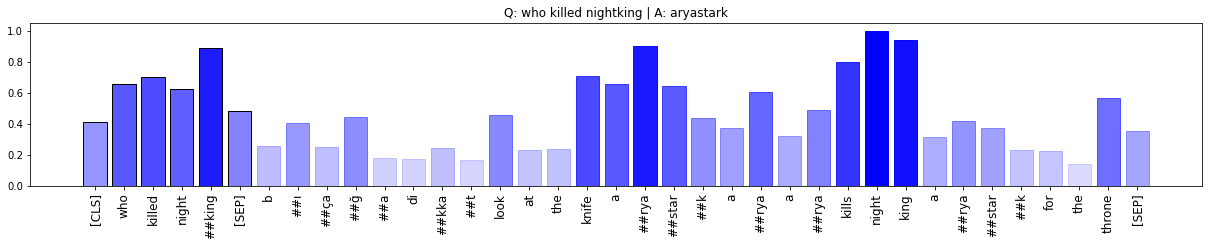

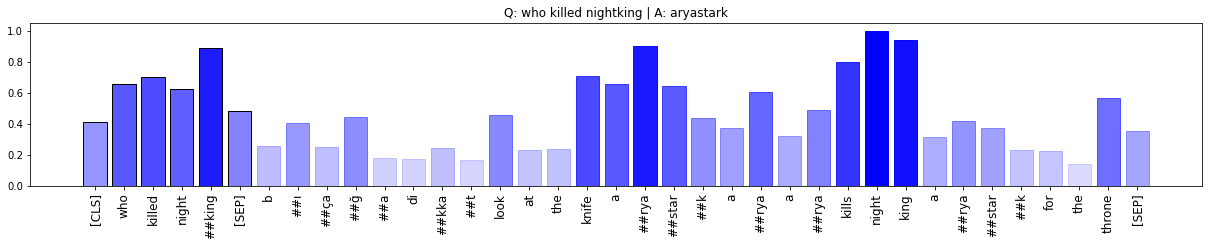

In [25]:
question = "who killed nightking"
context = """bıçağa dikkat look at the knife aryastark arya arya kills night king aryastark for the throne"""

gradients, tokens, token_types, answer  = explain_model(question, context, bqa_model, bqa_tokenizer)
# gradients, tokens, token_types = clean_tokens(gradients, tokens, token_types)

token_subset = -60
plot_gradients(tokens, token_types, gradients, "Q: " +question + " | A: "+ answer)
plot_gradients(tokens[token_subset:], token_types[token_subset:], gradients[token_subset:], "Q: " +question + " | A: " + answer)

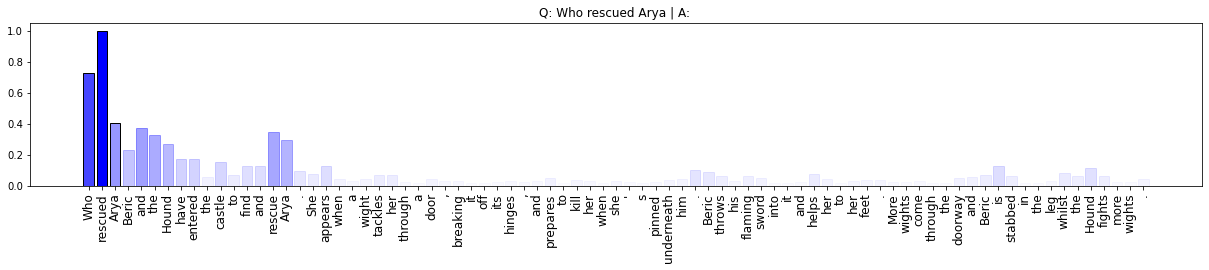

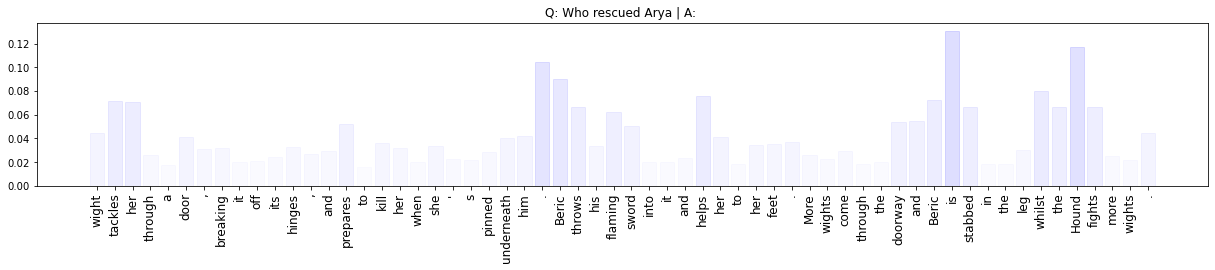

In [8]:
question = "Who rescued Arya"
context = """Beric and the Hound have entered the castle to find and rescue Arya. She appears when a wight tackles her through a door, breaking it off its hinges, and prepares to kill her when she's pinned underneath him. Beric throws his flaming sword into it and helps her to her feet. More wights come through the doorway 
and Beric is stabbed in the leg whilst the Hound fights more wights. """

gradients, tokens, token_types, answer  = explain_model(question, context, bqa_model, bqa_tokenizer)
gradients, tokens, token_types = clean_tokens(gradients, tokens, token_types)

token_subset = -60
plot_gradients(tokens, token_types, gradients, "Q: " +question + " | A: "+ answer)
plot_gradients(tokens[token_subset:], token_types[token_subset:], gradients[token_subset:], "Q: " +question + " | A: " + answer)

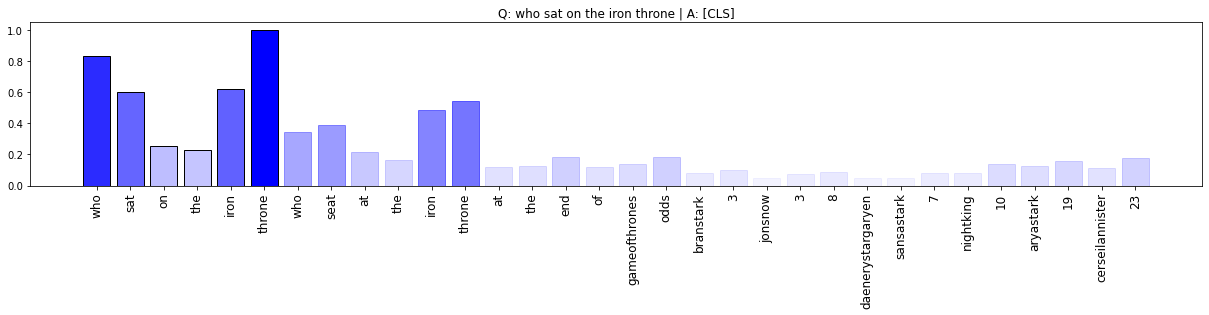

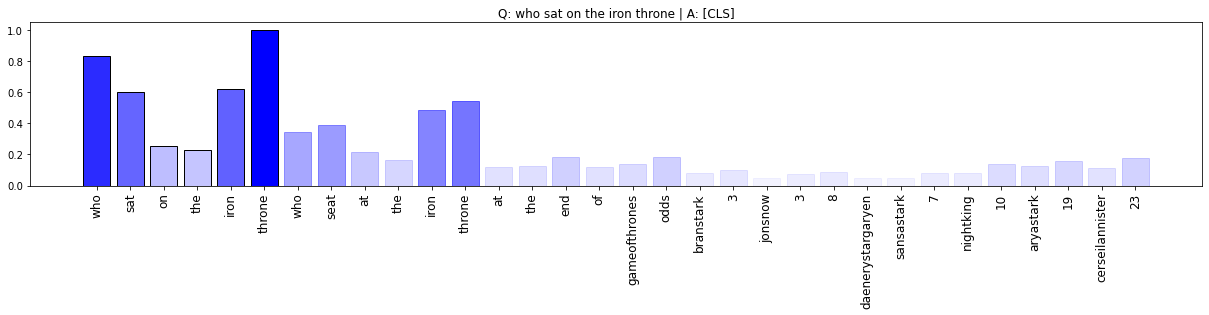

In [43]:
question = "who sat on the iron throne"
context = """who seat at the iron throne at the end of gameofthrones odds branstark 3 jonsnow 3 8 daenerystargaryen sansastark 7 nightking 10 aryastark 19 cerseilannister 23"""

gradients, tokens, token_types, answer  = explain_model(question, context, bqa_model, bqa_tokenizer)
gradients, tokens, token_types = clean_tokens(gradients, tokens, token_types)

token_subset = -60
plot_gradients(tokens, token_types, gradients, "Q: " +question + " | A: "+ answer)
plot_gradients(tokens[token_subset:], token_types[token_subset:], gradients[token_subset:], "Q: " +question + " | A: " + answer)